In [32]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import numpy as np
import pandas as pd
import scipy.stats as scs
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
CSV_PATH = "../data/processed.csv"

In [3]:
# taking a csv file path and reading a dataframe

def read_proccessed_data(csv_path):
    try:    
        df = pd.read_csv(csv_path)
        print("file read as csv")
        return df
    except FileNotFoundError:
        print("file not found")

In [5]:
## getting number of columns, row and column information
def get_data_info(Ilog_df: pd.DataFrame):
    
    row_count, col_count = Ilog_df.shape
    
    print(f"Number of rows: {row_count}")
    print(f"Number of columns: {col_count}")

    return Ilog_df.info()

In [6]:
## basic statistics of each column and see the data at glance
def get_statistics_info(Ilog_df: pd.DataFrame):
    
    return Ilog_df.describe(include='all')

In [8]:
# reading the extracted impression_log data and getting information
Ilog_df = read_proccessed_data(CSV_PATH)
get_data_info(Ilog_df)

get_statistics_info(Ilog_df)
Ilog_df.head(3)

file read as csv
Number of rows: 99999
Number of columns: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          99999 non-null  object 
 1   LogEntryTime        99999 non-null  object 
 2   AdvertiserId        99999 non-null  object 
 3   CampaignId          99999 non-null  object 
 4   AdGroupId           99999 non-null  object 
 5   AudienceID          99999 non-null  object 
 6   CreativeId          99999 non-null  object 
 7   AdFormat            99999 non-null  object 
 8   Frequency           99999 non-null  int64  
 9   Site                99999 non-null  object 
 10  FoldPosition        99999 non-null  int64  
 11  Country             99999 non-null  object 
 12  Region              99999 non-null  object 
 13  City                99999 non-null  object 
 14  DeviceType          99999 non-null  int64

,Unnamed: 0,LogEntryTime,AdvertiserId,CampaignId,AdGroupId,AudienceID,CreativeId,AdFormat,Frequency,Site,...,DeviceType,OSFamily,OS,Browser,DeviceMake,AdvertiserCurrency,click,engagement,video-end,video-start
0,00006a06-14e2-47d9-b999-fbeeac67dd2b,2021-09-25 00:22:37,868ko1s,t29si1w,e9qf2dm,0,9wkrkl5j,300x250,0,scrabblewordfinder.org,...,4,5.0,173.0,7.0,Apple,0.006409,0,0,0,0
1,00007898-29c9-43f1-82e5-43c5a856d0f4,2021-09-25 02:31:35,868ko1s,fiwemi8,8m750eh,0,zhre4utp,300x250,0,www.thecoli.com,...,4,5.0,173.0,7.0,Apple,0.002778,0,0,0,0
2,0000d06f-5239-4123-af41-bd1c0e0e8d48,2021-09-25 20:12:52,868ko1s,awbu4q4,oropida,lnqjhqm,ab6spdyi,300x250,0,www.today.com,...,4,6.0,156.0,6.0,Samsung,0.008947,0,0,0,0


In [11]:
df=Ilog_df[['engagement','AdFormat','FoldPosition','DeviceType','OS','Browser']]

In [12]:
df.head()

,engagement,AdFormat,FoldPosition,DeviceType,OS,Browser
0,0,300x250,4,4,173.0,7.0
1,0,300x250,2,4,173.0,7.0
2,0,300x250,3,4,156.0,6.0
3,0,300x250,4,4,101.0,7.0
4,1,300x250,3,4,101.0,7.0


In [13]:
df.dtypes

engagement        int64
AdFormat         object
FoldPosition      int64
DeviceType        int64
OS              float64
Browser         float64
dtype: object

In [15]:
def encode_labels(df):
    AdFormat_encoder = preprocessing.LabelEncoder()
    df['AdFormat'] = AdFormat_encoder.fit_transform(df['AdFormat'])
    return df

In [19]:
encoded=encode_labels(df)

In [21]:
encoded.head()

,engagement,AdFormat,FoldPosition,DeviceType,OS,Browser
0,0,0,4,4,173.0,7.0
1,0,0,2,4,173.0,7.0
2,0,0,3,4,156.0,6.0
3,0,0,4,4,101.0,7.0
4,1,0,3,4,101.0,7.0


In [23]:
cols = ['OS', 'Browser']
encoded[cols] = encoded[cols].applymap(np.int64)

In [25]:
##loss function
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse

In [34]:
## read model
def read_model(file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        return pickle.load(f)
## save model
def write_model(file_name, model):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        pickle.dump(model, f)

###   Logestic Regression Model training

In [27]:
class LogesticRegressionModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, model_name="LR"):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model_name = model_name
        
        self.clf = LogisticRegression()
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        model_name= self.model_name
        mlflow.end_run()
        for i in range(folds):

            train_index, valid_index = next(iterator)

            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]

            self.clf = self.clf.fit(X_train, y_train)

            vali_pred = self.clf.predict(X_valid)

            accuracy = self.calculate_score(y_valid, vali_pred)
            loss = loss_function(y_valid, vali_pred)

            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()

            acc_arr.append(accuracy)
            loss_arr.append(loss)
            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(self.y_test, y_pred)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss, report, matrix 
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of LogesticRegression is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of LogesticRegression is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    
    def get_p_values(self):
        """ 
        Calcualting p_values for logestic regression.
        code refered from the following link
        https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
        
        """
        denom = (2.0*(1.0+np.cosh(self.clf.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.clf.coef_[0]/sigma_estimates # z-score 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
        p_df = pd.DataFrame()
        p_df['features'] = self.X_train.columns.to_list()
        p_df['p_values'] = p_values
        
        return p_df
    
    def plot_pvalues(self, p_df):
        
        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot([0.05,0.05], [0.05,5])
        sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
        plt.title("P values of features", size=20)

        plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()
        return fig

In [50]:
import datetime
Current_Date = datetime.datetime.today()

mlflow.set_experiment('ML_Approach_logestic-' + str(Current_Date))

INFO: 'ML_Approach_logestic-2021-10-01 10:18:07.770858' does not exist. Creating a new experiment


In [51]:
feature_cols = ['AdFormat','FoldPosition','DeviceType','OS','Browser']

X = encoded[feature_cols]
y = encoded[['engagement']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [52]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

write_model('Logestic_Reg_model', clf2)

step 0: Validation Accuracy of LogesticRegression is: 0.872
step 0: Validation Loss of LogesticRegression is: 0.358

step 1: Validation Accuracy of LogesticRegression is: 0.866
step 1: Validation Loss of LogesticRegression is: 0.366

step 2: Validation Accuracy of LogesticRegression is: 0.872
step 2: Validation Loss of LogesticRegression is: 0.357

step 3: Validation Accuracy of LogesticRegression is: 0.869
step 3: Validation Loss of LogesticRegression is: 0.362

step 4: Validation Accuracy of LogesticRegression is: 0.873
step 4: Validation Loss of LogesticRegression is: 0.357



In [53]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

step 1: Test Accuracy of LogesticRegression is: 0.875
Test Metrics
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     10000
           1       0.00      0.00      0.00         0

    accuracy                           0.87     10000
   macro avg       0.50      0.44      0.47     10000
weighted avg       1.00      0.87      0.93     10000



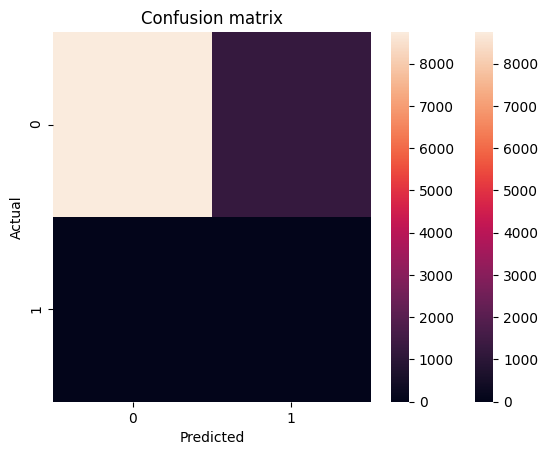

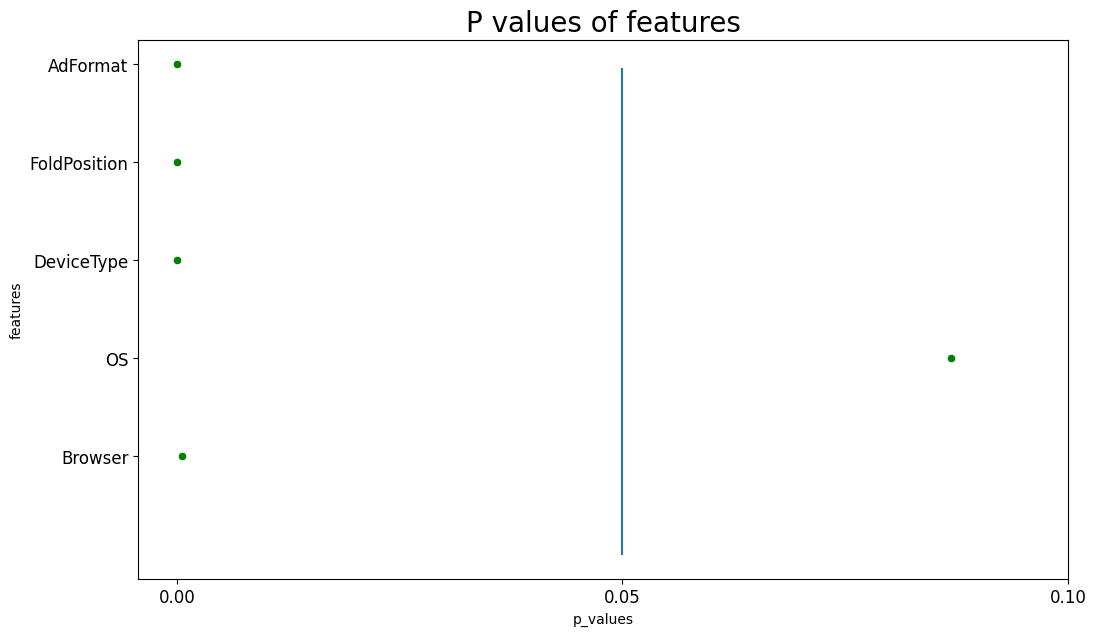

,features,p_values
0,AdFormat,4.502335e-263
1,FoldPosition,1.466998e-17
2,DeviceType,0.000000e+00
3,OS,8.681124e-02
4,Browser,5.522971e-04


In [54]:
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

In [57]:
mlflow.end_run()
with mlflow.start_run(run_name="Browser-DF-Logestic-Reg"):
    mlflow.log_param('Features', X_train.columns.to_list())
    mlflow.log_param('Target', y_train.columns.to_list())
    mlflow.log_param('Number Of Training Dataset', X_train.shape[0])
    mlflow.log_param('Number Of Test Dataset', X_test.shape[0])
    mlflow.log_param('Fold number', folds)
    
    mlflow.log_metric('Validation Accuray', acc_arr_2[-1])
    mlflow.log_metric('Validation Loss', acc_arr_2[-1])
    mlflow.log_metric('Test accuracy', test_acc2)
    mlflow.log_metric('Test Loss MSE', test_loss2)
    
    mlflow.log_figure(p_value_fig, 'fig.png')


### Decision Tree model training

In [58]:
class DecisionTreesModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = DecisionTreeClassifier(max_depth=4)
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)

In [59]:
feature_cols = ['AdFormat','FoldPosition','DeviceType','OS','Browser']

X = encoded[feature_cols]
y = encoded[['engagement']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [60]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)

write_model('decision_tree_model', clf)

step 0: Validation Accuracy of DecisionTreesModel is: 0.872
step 0: Validation Loss of DecisionTreesModel is: 0.358

step 1: Validation Accuracy of DecisionTreesModel is: 0.866
step 1: Validation Loss of DecisionTreesModel is: 0.366

step 2: Validation Accuracy of DecisionTreesModel is: 0.872
step 2: Validation Loss of DecisionTreesModel is: 0.357

step 3: Validation Accuracy of DecisionTreesModel is: 0.869
step 3: Validation Loss of DecisionTreesModel is: 0.362

step 4: Validation Accuracy of DecisionTreesModel is: 0.873
step 4: Validation Loss of DecisionTreesModel is: 0.357



#### Evaluating our model

In [61]:
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

step 1: Test Accuracy of DecisionTreesModel is: 0.875
Test Metrics
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     10000
           1       0.00      0.00      0.00         0

    accuracy                           0.87     10000
   macro avg       0.50      0.44      0.47     10000
weighted avg       1.00      0.87      0.93     10000

Loss on test data is: 0.354



#### Calculating feature importance

In [62]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,AdFormat,0.482711
1,FoldPosition,0.160806
2,DeviceType,0.143731
3,OS,0.106706
4,Browser,0.106046


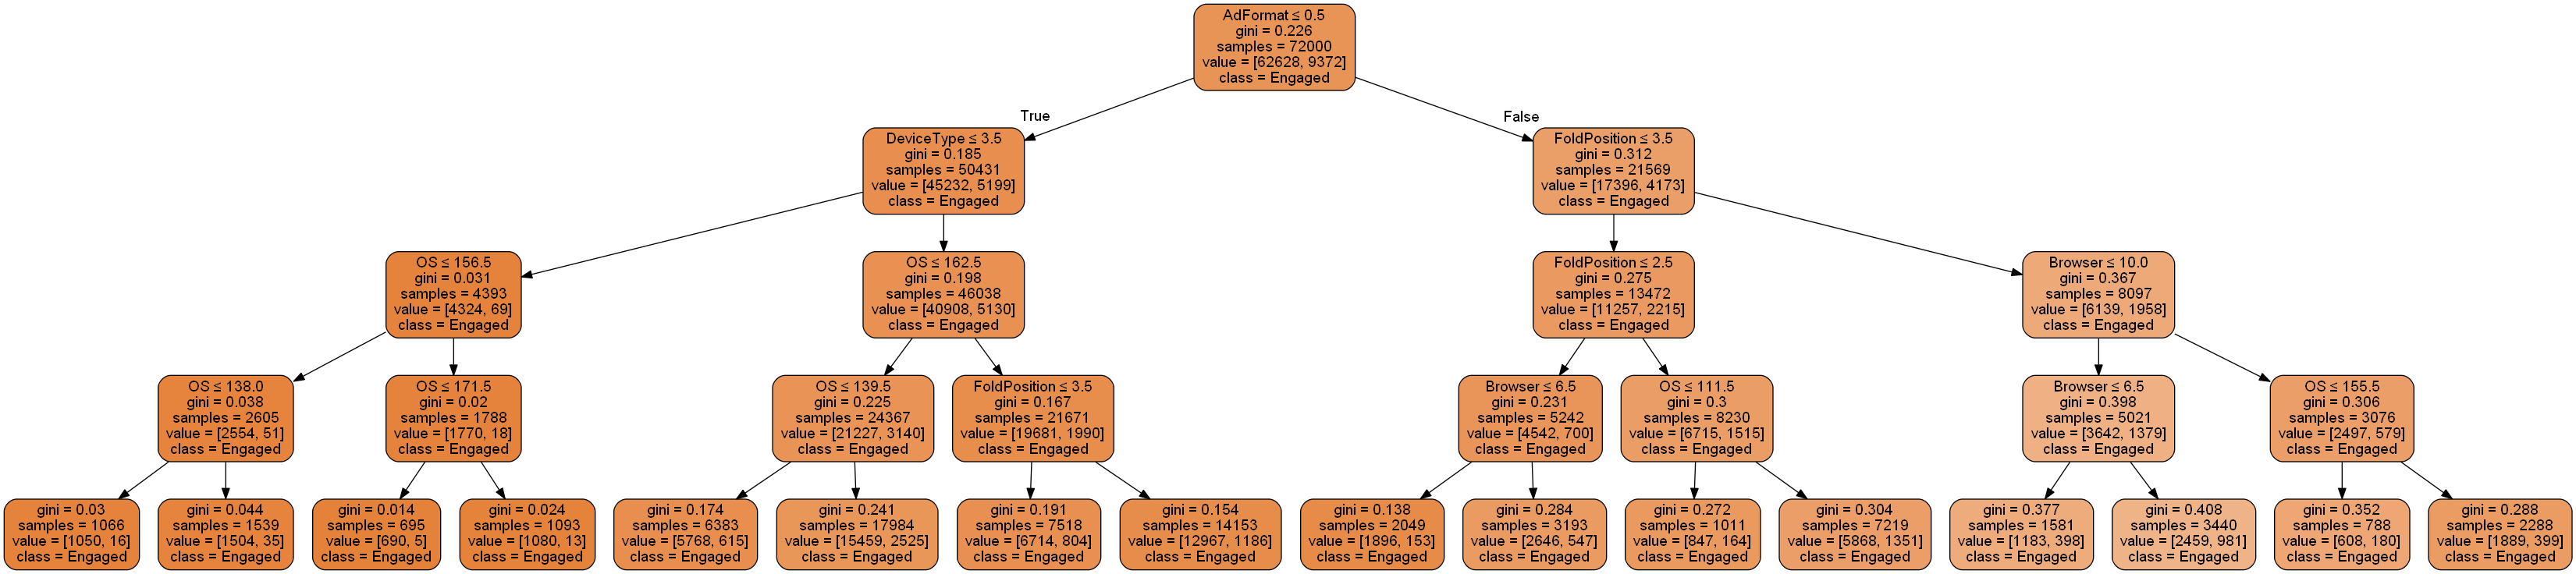

In [63]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ['AdFormat','FoldPosition','DeviceType','OS','Browser']
out_put_file = "DecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Engaged','Not Engaged'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('DecisionTree.png')

Image(graph.create_png())